In [106]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [62]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()

In [108]:
stock_symbol = 'AAPL'
df = yf.download(stock_symbol, start=start, end=end)
df.tail(10)
yesterday_date = df.index[-1].strftime('%Y-%m-%d')

[*********************100%***********************]  1 of 1 completed

Yesterday's date: 2024-10-15


In [64]:
df.shape

(2463, 6)

In [65]:
df = df[['Close']]
df.head()

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500


In [66]:
df.shape

(2463, 1)

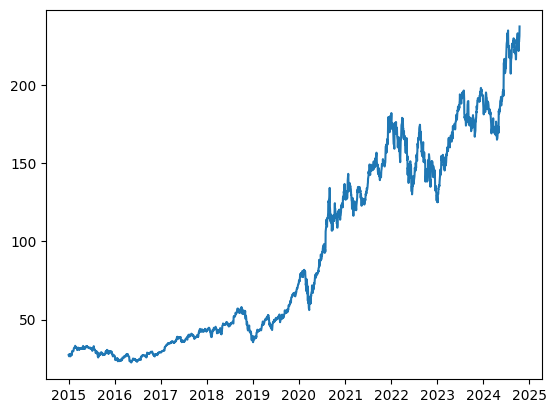

In [67]:
plt.plot(df)

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [69]:
df

array([[0.02210392],
       [0.01851887],
       [0.01853051],
       ...,
       [0.95429766],
       [0.9717573 ],
       [1.        ]])

# Train Test Split

In [70]:
# incase of timeseries data we should split on the basis of dates (continious)
training_size = int(len(df)*0.65)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size, :], df[training_size:len(df), :]

In [71]:
print(train_data.shape)
print(test_data.shape)

(1600, 1)
(863, 1)


In [72]:
# timesteps = 3
# f1  f2  f3  y(o/p)
# x1  x2  x2   y1                           output depends on previous 3 values


In [73]:
def createdataset(dataset, timestep=1):
  dataX,dataY = [],[]
  for i in range(len(dataset)-timestep):
    a = dataset[i:(i+timestep), 0]
    dataX.append(a)
    dataY.append(dataset[i+timestep, 0])
  return np.array(dataX), np.array(dataY)

In [74]:
timestep = 100
Xtrain, ytrain = createdataset(train_data, timestep)
Xtest, ytest = createdataset(test_data, timestep)

In [75]:
print(Xtrain.shape),print(ytrain.shape)
print(Xtest.shape),print(ytest.shape)

(1500, 100)
(1500,)
(763, 100)
(763,)


(None, None)

# Creating a Stacked LSTM

In [76]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [78]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0163 - val_loss: 0.0019
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4338e-04 - val_loss: 0.0024
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3961e-04 - val_loss: 0.0018
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0609e-04 - val_loss: 0.0021
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8243e-04 - val_loss: 0.0019
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9969e-04 - val_loss: 0.0026
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.8443e-04 - val_loss: 0.0042
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7290e-04 - val_loss: 0.0034
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3900e-04 - val_loss: 0.0039
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7029e-04 - val_loss: 0.0021
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4145e-04 - val_loss: 0.0031
Epoch 12/100

In [81]:
tf.__version__

'2.17.0'

In [82]:
train_predict = model.predict(Xtrain)
test_predict = model.predict(Xtest)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [83]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [84]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(ytrain, train_predict))

62.79432770264174

In [85]:
math.sqrt(mean_squared_error(ytest, test_predict))

169.50036419072438

In [86]:
# # plotting
# look_back=100
# trainPredictPlot = np.empty_like(df)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# testPredictPlot = np.empty_like(df)
# testPredictPlot[:, :] = np.nan
# # Adjust the slicing to ensure the target slice has the same size as test_predict
# testPredictPlot[len(train_predict)+(look_back)+1:len(train_predict)+(look_back)+1 + len(test_predict), :] = test_predict

# plt.plot(scaler.inverse_transform(df))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

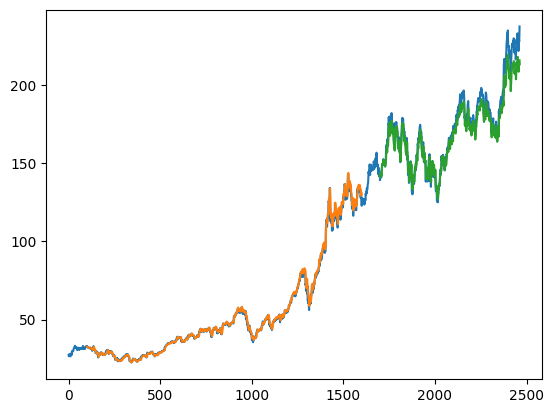

In [87]:
# plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2): len(df)] = test_predict

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [88]:
# predicting future 30 days

len(test_data)

863

In [89]:
x_input = test_data[len(test_data)-100:].reshape(1, -1)
x_input.shape

(1, 100)

In [90]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [91]:
temp_input

[0.7649419974406587,
 0.7793752614177969,
 0.7794218659391815,
 0.780818580711163,
 0.785474486067042,
 0.789944186467816,
 0.7982316923178023,
 0.799721616132553,
 0.8067985411221851,
 0.8003268355192523,
 0.8115475844773553,
 0.7939948013935179,
 0.8593171478530217,
 0.8868801700780857,
 0.8923275708192467,
 0.8841797364464585,
 0.9036413867331633,
 0.8925603092522585,
 0.8710965827199173,
 0.8609002096670636,
 0.8639265197309939,
 0.8682565486545698,
 0.8877181989412746,
 0.8916757469111628,
 0.8754731451214,
 0.9040138676868511,
 0.9204026744317187,
 0.9263622276037656,
 0.9486639829992959,
 0.9555547740773006,
 0.9595587844816179,
 0.979579191720593,
 0.9543907977383309,
 0.968218771285292,
 0.9861905688007239,
 0.9881461115684534,
 0.960490022387576,
 0.9386072103801625,
 0.9392125008103397,
 0.9375829765618687,
 0.9424716203507594,
 0.9123479070147441,
 0.9074592632258535,
 0.9096475444265949,
 0.9109511922427628,
 0.9135584878750985,
 0.9288298517589034,
 0.9115098781515553,
 0

In [92]:
from numpy import array

lst_output = []
n_steps = 100
i = 0
while (i < 30):
  if len(temp_input) > 100:
    x_input = np.array(temp_input[1:])
    print('{} day input {}'.format(i,x_input))
    x_input = x_input.reshape(1, -1)
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print('{} day output {}'.format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print('{} day output {}'.format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1

print(lst_output)

0 day output [[0.92268646]]
101
1 day input [0.77937526 0.77942187 0.78081858 0.78547449 0.78994419 0.79823169
 0.79972162 0.80679854 0.80032684 0.81154758 0.7939948  0.85931715
 0.88688017 0.89232757 0.88417974 0.90364139 0.89256031 0.87109658
 0.86090021 0.86392652 0.86825655 0.8877182  0.89167575 0.87547315
 0.90401387 0.92040267 0.92636223 0.94866398 0.95555477 0.95955878
 0.97957919 0.9543908  0.96821877 0.98619057 0.98814611 0.96049002
 0.93860721 0.9392125  0.93758298 0.94247162 0.91234791 0.90745926
 0.90964754 0.91095119 0.91355849 0.92882985 0.91150988 0.91849374
 0.86918772 0.85968963 0.87174848 0.88799754 0.90163938 0.90764547
 0.92505858 0.92715372 0.94112144 0.9473138  0.94656884 0.94945548
 0.94894333 0.94023681 0.95099194 0.95257493 0.95653247 0.94936241
 0.96472684 0.96104871 0.93204244 0.92310311 0.93022664 0.92296344
 0.92338245 0.91965771 0.93153029 0.93204244 0.93078532 0.90201186
 0.90420007 0.92235815 0.96044342 0.95732397 0.94926927 0.95345956
 0.94880365 0.9541

In [93]:
# plotting
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [94]:
len(df)

2463

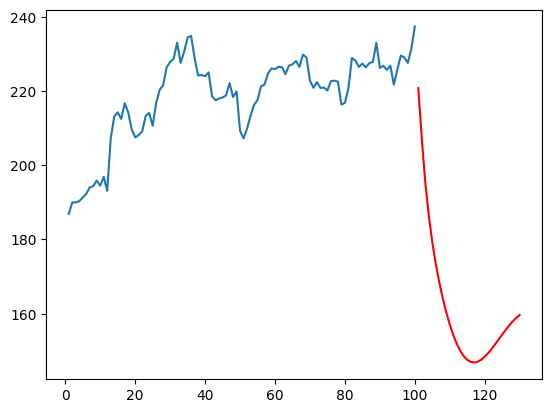

In [95]:
plt.plot(day_new, scaler.inverse_transform(df[len(df)-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output), c='r')

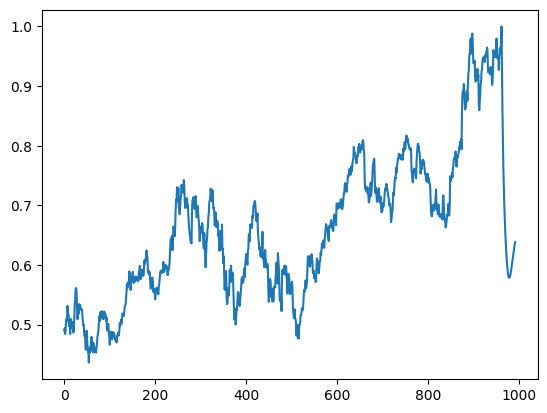

In [96]:
df3 = df.tolist()
df3.extend(lst_output)
plt.plot(df3[1500:])

In [99]:
# inverse transfrom lst_output

lst = scaler.inverse_transform(lst_output)
for i in range(len(lst)):
  print(f'Day {i+1} : {lst[i][0]}')

Day 1 : 220.7605175083818
Day 2 : 207.03159636134433
Day 3 : 195.33570090849298
Day 4 : 186.3768485169321
Day 5 : 179.27344603901975
Day 6 : 173.4155191963855
Day 7 : 168.44122101066478
Day 8 : 164.134083392094
Day 9 : 160.3706955898706
Day 10 : 157.08996672195826
Day 11 : 154.26923734552292
Day 12 : 151.90530697428858
Day 13 : 150.00138889647633
Day 14 : 148.5578799723844
Day 15 : 147.56721425245632
Day 16 : 147.01104654935807
Day 17 : 146.85972755822877
Day 18 : 147.07335361617925
Day 19 : 147.60385341934398
Day 20 : 148.39749720412146
Day 21 : 149.3979564120541
Day 22 : 150.54874886134303
Day 23 : 151.7956583144728
Day 24 : 153.08852675052594
Day 25 : 154.38225291690105
Day 26 : 155.63745803045822
Day 27 : 156.82079302420152
Day 28 : 157.90447767725527
Day 29 : 158.86631341680913
Day 30 : 159.6893248636552
